<a href="https://colab.research.google.com/github/JorgeMiguelGomes/fma-analysis-vostpt/blob/main/VOSTPT_FMA_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANALYSIS OF ADVERSE WEATHER PHENOMENA

## DATA VIA FOGOS.PT API

### OBJECTIVES

**This notebook allows you to analyze the data coming from the FOGOS.PT API and create summary views on a given phenomenon. The origin of the data provided by the API comes directly from ANEPC**

#### Install the necessary libraries that are not installed by default in Google Colab

In [ ]:
!pip install h3pandas
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.3 MB/s eta 0:00:00


#### Import required libraries

In [ ]:
import pandas as pd
import geopandas as gpd
import json
import h3pandas
import unidecode
import matplotlib.pyplot as plt
import requests
import datetime as dt
from datetime import datetime, timedelta, date
import seaborn as sns
import folium
from folium.plugins import HeatMap
import matplotlib.dates as mdates

#### Data Files
**API FOGOS.PT**

https://api.fogos.pt/v2/incidents/search?all=1&after=2023-10-16&limit=30000

**Please change the date to the day before the day you want to analyse**

In [ ]:
# Define the call to the API
url_bar="https://api.fogos.pt/v2/incidents/search?all=1&after=2023-10-16&limit=30000"
# Get response from the API
response = requests.get(url_bar)
# Get the json content from the response
json = response.json()
# Create a pandas dataframe
data = pd.json_normalize(json,'data')
# Convert 'date' from string to datetime format
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')

In [ ]:
# Define the Perios that is being analysed
start_date = data['date'].min()
end_date = data['date'].max()

# Convert the timestamps to strings in the desired format
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

print(start_date_str,end_date_str)

2023-10-16 2023-10-18


#### Create sample dataframe for ChatGPT analysis
*This block should be deleted after the analysis is made*

In [ ]:
data_sample = data.head(500)
data_sample.to_csv('/content/drive/MyDrive/2023/FMA NOTEBOOK/data_sample.csv')

#### Main Statistics

In [ ]:
# Duplicate Dataframe for data integrity purposes
incident_data_full = data
# Convert 'dateTime.sec' from Unix time to regular time
incident_data_full['dateTime.sec'] = pd.to_datetime(incident_data_full['dateTime.sec'], unit='s')

# Count of Incidents
total_incidents = len(incident_data_full)


# Incidents by Type (Natureza)
incidents_by_natureza = incident_data_full['natureza'].value_counts()

# Incidents by Location (Concelho)
incidents_by_concelho = incident_data_full['concelho'].value_counts()
# Convert to DataFrame
incidents_by_concelho_df = incidents_by_concelho.reset_index()
incidents_by_concelho_df.columns = ['concelho', 'number_of_incidents']


# Incident Frequency Over Time (per hour)
## Extract the hour from the datetime
incident_data_full['hour'] = incident_data_full['dateTime.sec'].dt.hour
# Count the number of incidents for each hour
incidents_by_hour = incident_data_full['hour'].value_counts().sort_index()

# Response Statistics
# Calculating the average number of personnel (man) involved in incidents
average_personnel = incident_data_full['man'].mean()

# Find the incident with the most personnel involved
max_personnel_incident = incident_data_full.loc[incident_data_full['man'].idxmax()]

# Extract relevant information from the incident
max_personnel_natureza = max_personnel_incident['natureza']
max_personnel_concelho = max_personnel_incident['concelho']
max_personnel_district = max_personnel_incident['district']
max_personnel_count = max_personnel_incident['man']

# Collecting the results
statistics = {
    "total_incidents": total_incidents,
    "incidents_by_natureza": incidents_by_natureza,
    "incidents_by_concelho": incidents_by_concelho,
    "incidents_by_hour": incidents_by_hour,
    "average_personnel_per_incident": average_personnel,
}


# dictionary key and variable references
translation_dict = {
    "total_incidents": "Total de Ocorrências",
    "incidents_by_natureza": "Tipos de Ocorrências",
    "incidents_by_concelho": "Ocorrências por Concelho",
    "incidents_by_hour": "Frequência de Ocorrências ao Longo do Tempo (por hora)",
    "average_personnel_per_incident": "Média de Operacionais por Ocorrência",
    "max_personnel_incident": "Ocorrência com Mais Operacionais Envolvidos"
}

# Convert statistics dictionary keys and certain values to Portuguese
statistics_pt = {translation_dict[key]: value if key not in ['incidents_by_natureza', 'incidents_by_concelho'] else {sub_key: sub_value for sub_key, sub_value in value.items()} for key, value in statistics.items()}

# Generate a summary text in Portuguese, and make sure to use the correct keys
summary_text = f"""
1. **{translation_dict['total_incidents']}:** {statistics['total_incidents']} ocorrências
2. **{translation_dict['incidents_by_natureza']}:** Os tipos de ocorrências mais comuns foram: {', '.join([f'"{natureza}" ({count} ocorrências)' for natureza, count in statistics['incidents_by_natureza'].items()])}.
3. **{translation_dict['incidents_by_concelho']}:** OS concelhos com mais ocorrências foram: {', '.join([f'"{concelho}" ({count} ocorrências)' for concelho, count in statistics['incidents_by_concelho'].items()])}.
4. **{translation_dict['incidents_by_hour']}:** A hora com mais ocorrências foi às {statistics['incidents_by_hour'].idxmax()}h00 ({statistics['incidents_by_hour'].max()} ocorrências).
5. **{translation_dict['average_personnel_per_incident']}:** Em média, cerca de {statistics['average_personnel_per_incident']:.2f} operacionais estiveram envolvidos por ocorrência.
6. **{translation_dict['max_personnel_incident']}:** A ocorrência com mais operacionais envolveu {max_personnel_count} operacionais. Ocorrência de natureza {max_personnel_natureza} no concelho de {max_personnel_concelho}, distrito de {max_personnel_district}.
Estas estatísticas fornecem insights sobre a frequência, natureza, timing, e resposta às ocorrências no conjunto de dados. Eles podem ser valiosos para o planeamento de recursos, compreensão dos fatores de risco, e implementação de medidas preventivas.
"""

print(summary_text)


1. **Total de Ocorrências:** 1832 ocorrências
2. **Tipos de Ocorrências:** Os tipos de ocorrências mais comuns foram: "Queda de Árvore" (701 ocorrências), "Inundação de estruturas ou superfícies por precipitação intensa" (250 ocorrências), "Despiste" (194 ocorrências), "Colisão rodoviária" (152 ocorrências), "Queda de elementos de construção em estruturas edificadas" (82 ocorrências), "Dano ou Queda de redes de fornecimento eléctrico" (57 ocorrências), "Queda de estruturas temporárias ou móveis" (48 ocorrências), "Busca e Resgate Terrestre, de Animais" (45 ocorrências), "Atropelamento rodoviário" (40 ocorrências), "Habitacional" (33 ocorrências), "Equipamentos" (32 ocorrências), "Movimento de massa" (27 ocorrências), "Corte ou Remoção de elementos em perigo de queda" (23 ocorrências), "Rodoviário" (20 ocorrências), "Desabamento de estruturas edificadas" (18 ocorrências), "Detritos não confinados" (15 ocorrências), "Detritos confinados" (13 ocorrências), "Inundação de estruturas por ág

## DATA VISUALISATION

#### Ocorrências por Distrito
**Esta visualização mostra uma tabela cromática pelo tipo de ocorrências (top 10) e por distrito**

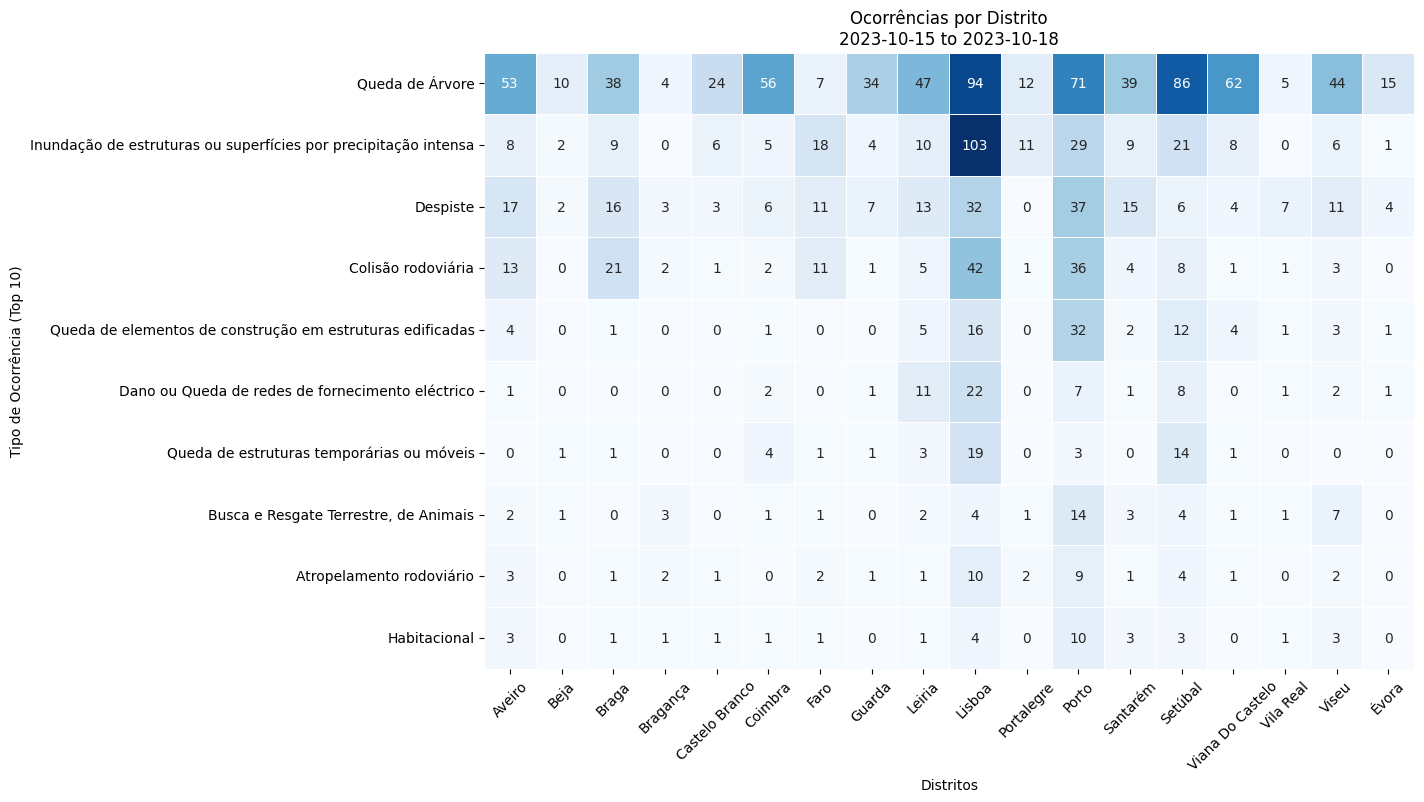

In [ ]:
# Calculate the frequency of each 'natureza' for each district
natureza_district_crosstab = pd.crosstab(incident_data_full['natureza'], incident_data_full['district'])

# Get the top 10 'natureza' types
top_naturezas = incident_data_full['natureza'].value_counts().nlargest(10).index

# Filter the crosstab for only the top 10 'natureza' types
top_natureza_district_crosstab = natureza_district_crosstab.loc[top_naturezas]

# Assuming you have a 'datetime' column in 'incident_data_full'
start_date = incident_data_full['dateTime.sec'].min()
end_date = incident_data_full['dateTime.sec'].max()

# Convert the timestamps to strings in the desired format
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_natureza_district_crosstab, annot=True, fmt="d", cmap='Blues', linewidths=.5,cbar=False)

# Set the labels
plt.xlabel('Distritos')
plt.ylabel('Tipo de Ocorrência (Top 10)')
plt.title(f'Ocorrências por Distrito\n{start_date_str} to {end_date_str}', loc='center')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
# Save the plot for dissemination

plt.savefig('/content/drive/MyDrive/2023/FMA NOTEBOOK/distrito_high_res.png', dpi=300, bbox_inches='tight')
plt.show()

#### Ocorrências por Concelho para o Distrito com mais Ocorrências.
**Novamente apenas se visualiazam o top 10 de ocorrências**

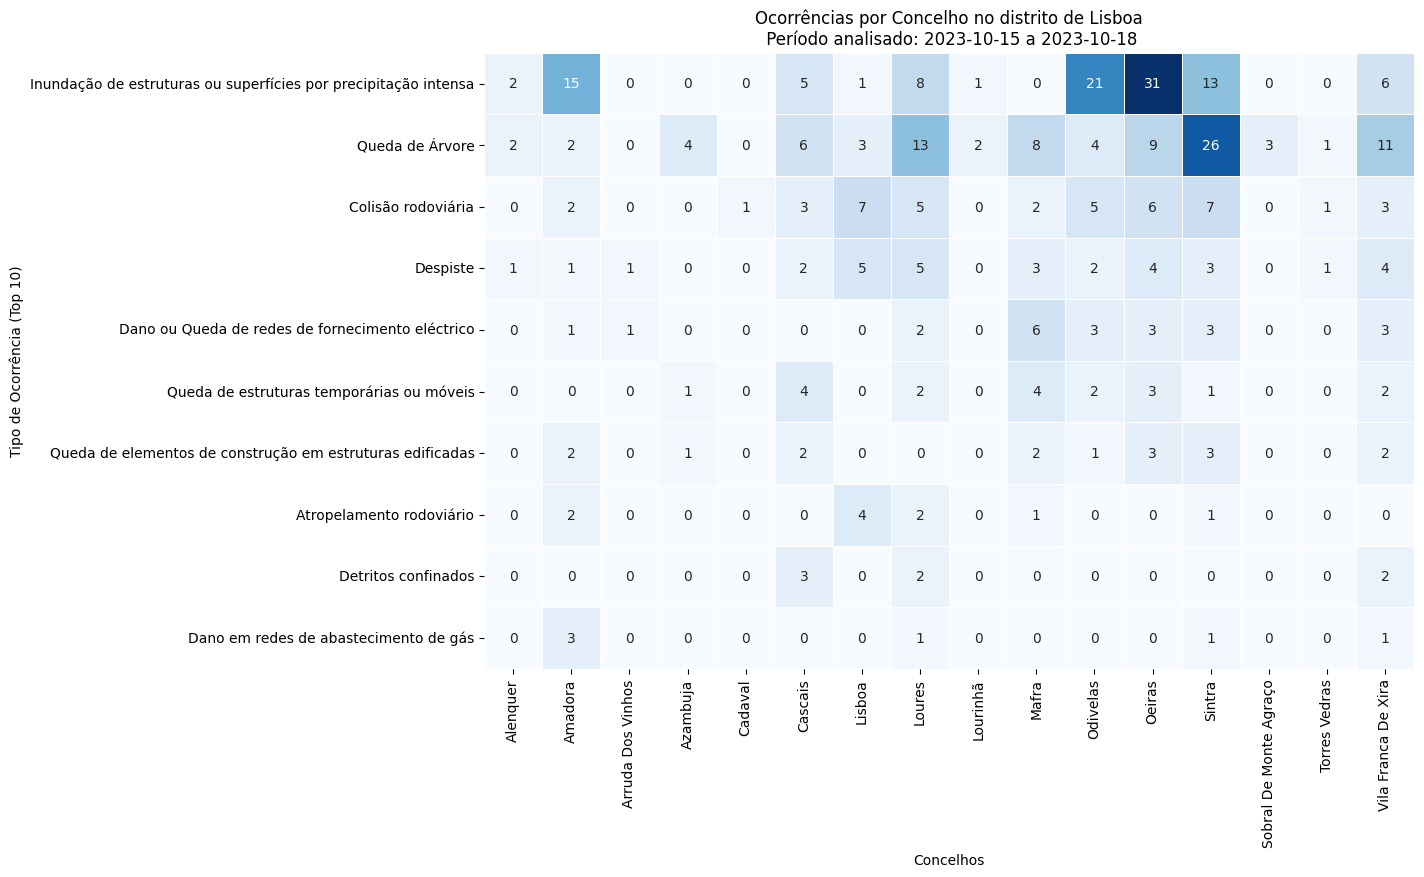

In [ ]:
# Identify the district with the most incidents
top_district = incident_data_full['district'].value_counts().idxmax()

# Filter the data for that district
district_data = incident_data_full[incident_data_full['district'] == top_district]

# Calculate the frequency of each 'natureza' for each 'concelho' in the top district
natureza_concelho_crosstab = pd.crosstab(district_data['natureza'], district_data['concelho'])

# Get the top 10 'natureza' types
top_naturezas = district_data['natureza'].value_counts().nlargest(10).index

# Filter the crosstab for only the top 10 'natureza' types
top_natureza_concelho_crosstab = natureza_concelho_crosstab.loc[top_naturezas]

# Create the heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(top_natureza_concelho_crosstab, annot=True, fmt="d", cmap='Blues', linewidths=.5, cbar=False)

# Set the labels and titles with the top district
plt.xlabel('Concelhos')
plt.ylabel('Tipo de Ocorrência (Top 10)')
plt.title(f'Ocorrências por Concelho no distrito de {top_district}\n Período analisado: {start_date_str} a {end_date_str}', loc='center')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Save the figure in high resolution
plt.savefig('/content/drive/MyDrive/2023/FMA NOTEBOOK/concelho_heatmap_high_res.png', dpi=300, bbox_inches='tight')

plt.show()


#### Ocorrências por Freguesia para o Concelho mais afetado
**Novamente apenas o top 10 do tipo de ocorrências é visualizado**


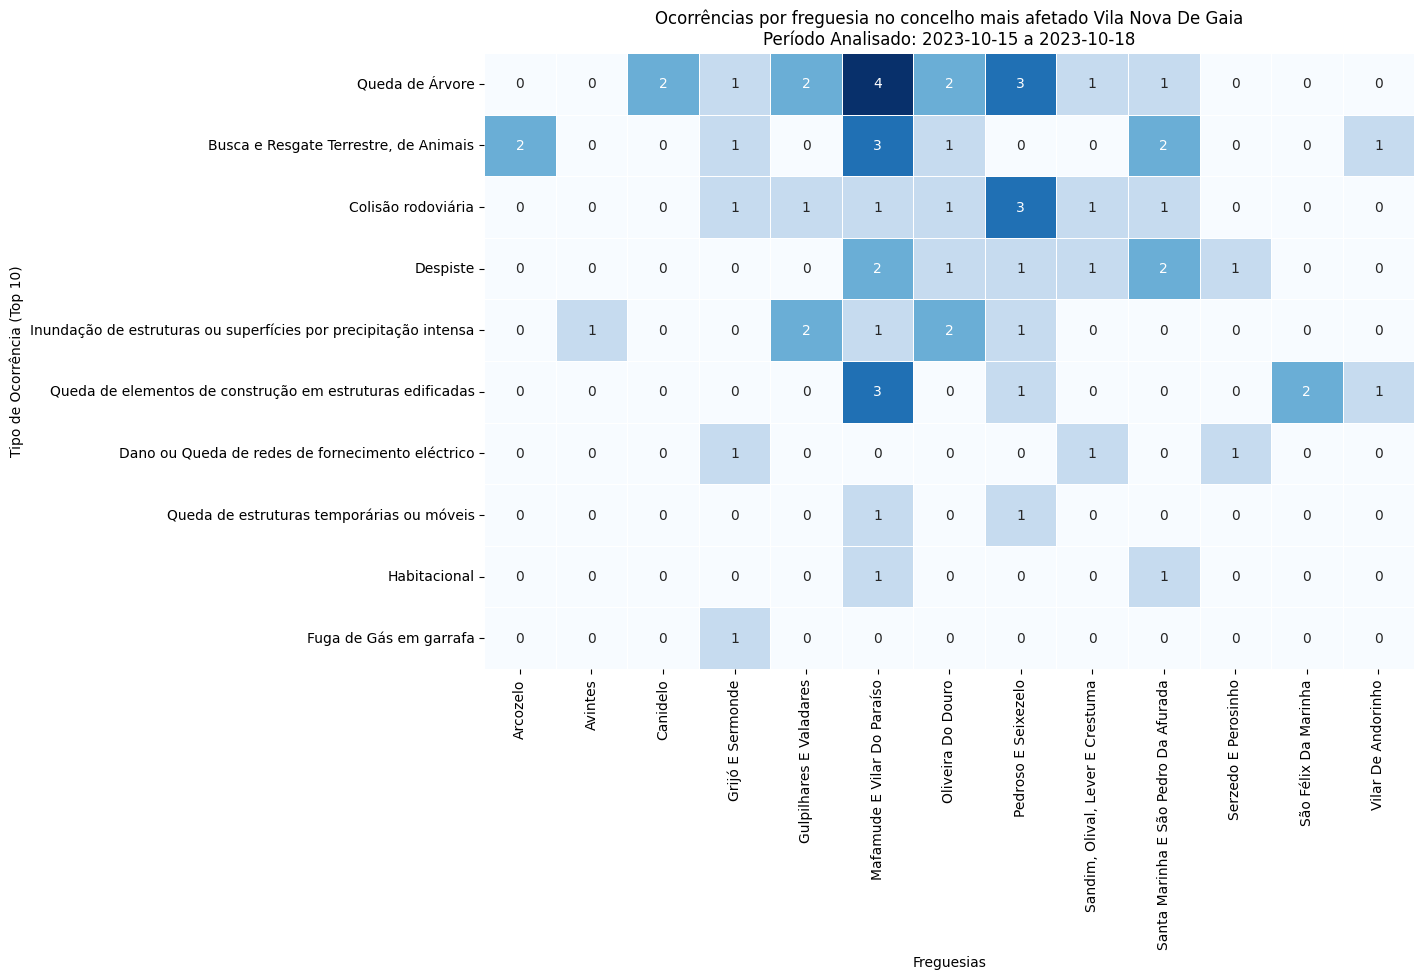

In [ ]:
# Identify the concelho with the most incidents across the entire dataset
top_concelho = incident_data_full['concelho'].value_counts().idxmax()

# Filter the data for that concelho
concelho_data = incident_data_full[incident_data_full['concelho'] == top_concelho]

# Calculate the frequency of each 'natureza' for each 'freguesia' in the top concelho
natureza_freguesia_crosstab = pd.crosstab(concelho_data['natureza'], concelho_data['freguesia'])

# Get the top 10 'natureza' types
top_naturezas_concelho = concelho_data['natureza'].value_counts().nlargest(10).index

# Filter the crosstab for only the top 10 'natureza' types
top_natureza_freguesia_crosstab = natureza_freguesia_crosstab.loc[top_naturezas_concelho]

# Create the heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(top_natureza_freguesia_crosstab, annot=True, fmt="d", cmap='Blues', linewidths=.5, cbar=False)

# Set the labels and titles with the top concelho
plt.xlabel('Freguesias')
plt.ylabel('Tipo de Ocorrência (Top 10)')
plt.title(f'Ocorrências por freguesia no concelho mais afetado {top_concelho}\nPeríodo Analisado: {start_date_str} a {end_date_str}', loc='center')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Save the figure in high resolution
plt.savefig('/content/drive/MyDrive/2023/FMA NOTEBOOK/freguesia_heatmap_high_res.png', dpi=300, bbox_inches='tight')

plt.show()

#### Mapa de calor

In [ ]:
# Create a base map with a dark theme
map = folium.Map(location=[39.3999, -8.2245], zoom_start=6, tiles='CartoDB dark_matter')  # coordinates for Portugal

# List of 'natureza' to create layers for
naturezas = incident_data_full['natureza'].unique()

# Layer control
layer_control = folium.LayerControl(collapsed=False)

# Define a blue gradient color scale
gradient = {0.2: 'blue', 0.4: 'deepskyblue', 0.6: 'cyan', 0.8: 'aqua', 1.0: 'white'}

# Create a heatmap layer for each 'natureza'
for natureza in naturezas:
    filtered_data = incident_data_full[incident_data_full['natureza'] == natureza]
    heat_data = [[row['lat'], row['lng']] for index, row in filtered_data.iterrows()]
    heat_layer = HeatMap(heat_data, name=natureza, show=False, gradient=gradient,radius=10)
    heat_layer.add_to(map)

# Add layer control to the map
layer_control.add_to(map)

# Save it to a file
map.save('/content/drive/MyDrive/2023/FMA NOTEBOOK/heatmap_natureza_layers_dark.html')

# Display the map
map

### Mapa de Colmeia
**Este mapa mostra a distribuição por Distrito, num formato hexagonal**

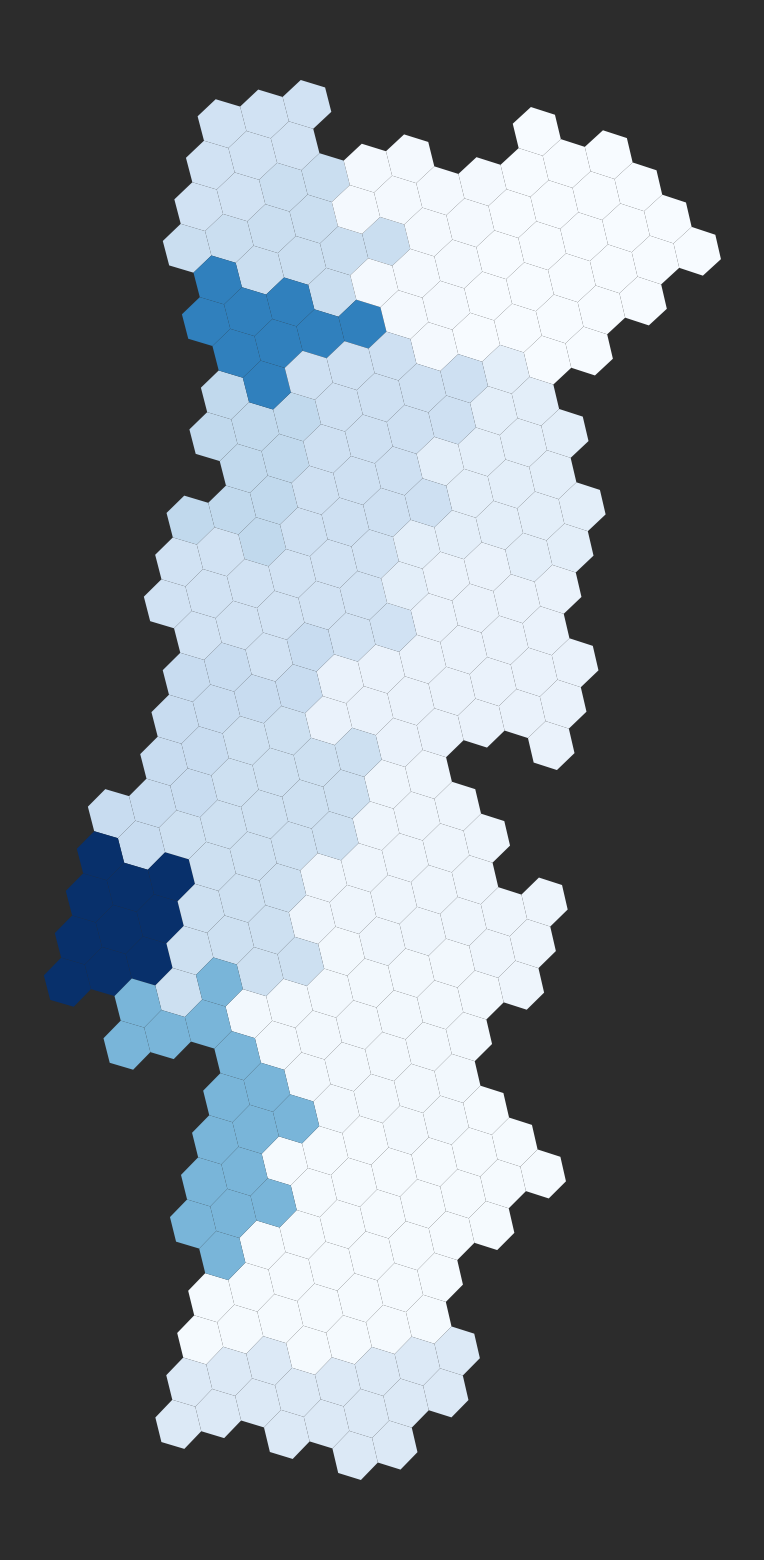

In [ ]:
# Load and inspect the district shapefile
districts_gdf = gpd.read_file('/content/drive/MyDrive/2023/FMA BABET/distritos.shp')
# Exclude rows where 'TYPE_1' is 'Regiões autônomas'
districts_gdf = districts_gdf[districts_gdf['TYPE_1'] != 'Regiões autônomas']
# define the size of the hexagons
resolution = 5
# if it's not set or incorrect, set to the correct CRS (assuming EPSG:4326 here)
districts_gdf = districts_gdf.set_crs("EPSG:4326", allow_override=True)
# Create the Hexagons
hexagons = districts_gdf.h3.polyfill_resample(resolution)

# Create dataframe that counts the numnber of occurrences per district
total_incidents_by_district = data.groupby('district').size().reset_index(name='total_incident_count')

# Create uniformity between District Names
hexagons['district'] = hexagons['NAME_1'].str.upper().apply(unidecode.unidecode)
total_incidents_by_district['district'] = total_incidents_by_district['district'].str.upper().apply(unidecode.unidecode)

# Now, you should be able to merge and plot as previously described
merged_gdf = hexagons.merge(total_incidents_by_district, on='district', how='left')

# Replace NaNs with 0s (assuming that NaN means no incidents)
merged_gdf['total_incident_count'] = merged_gdf['total_incident_count'].fillna(0)

# Create the plot with a large figure size
fig, ax = plt.subplots(1, 1, figsize=(20, 20))  # You can adjust the size as needed

# Set a dark grey background color
fig.patch.set_facecolor('#2c2c2c')
ax.set_facecolor('#2c2c2c')

# Plot the hexagons, colored by total_incident_count using a blue color scheme
merged_gdf.plot(column='total_incident_count', ax=ax, cmap='Blues', legend=False)

# Remove axes for a cleaner look
ax.set_axis_off()

# Show the plot
plt.show()

# Save the figure with high resolution
fig.savefig('/content/drive/MyDrive/2023/FMA NOTEBOOK/mapa_colmeia_large_map.png', dpi=300, facecolor=fig.get_facecolor(), edgecolor='none')

## TIME ANALYSIS

#### Número de Ocorrências diárias

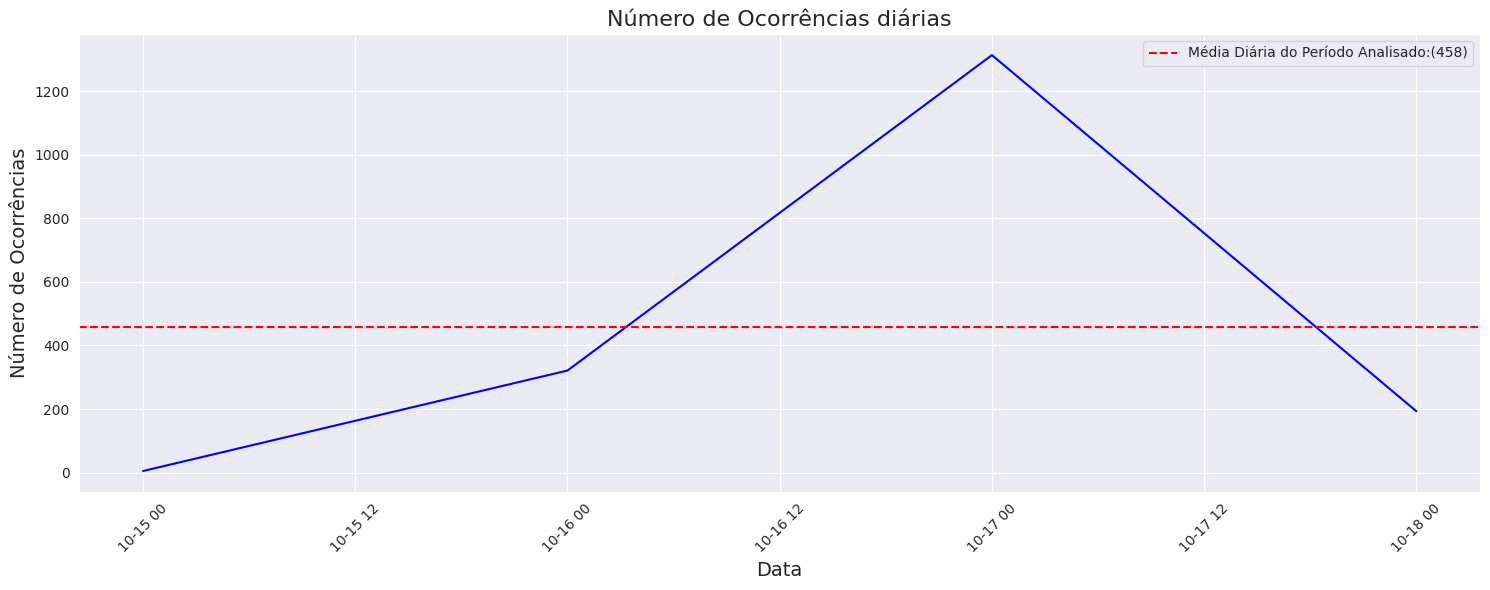

In [ ]:
incident_data_full = data
# Convert 'dateTime.sec' from Unix time to regular time
incident_data_full['date'] = pd.to_datetime(incident_data_full['dateTime.sec'], unit='s').dt.date

# Extract date from datetime for daily analysis
incident_data_full['date'] = incident_data_full['dateTime.sec'].dt.date

# Group the data by date and count the number of incidents for each day
daily_counts = incident_data_full.groupby('date').size()

# Calculate the average number of incidents per day
average_daily_incidents = daily_counts.mean()

# Create a time series plot
plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
sns.lineplot(x=daily_counts.index, y=daily_counts, color="blue")
plt.axhline(y=average_daily_incidents, color='red', linestyle='--', label=f'Média Diária do Período Analisado:({average_daily_incidents:.0f})')
plt.title("Número de Ocorrências diárias", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Número de Ocorrências", fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
#plt.savefig('/mnt/data/incidents_over_time_with_daily_average_improved.png', dpi=300)

plt.show()

#### Heatmap de Ocorrências por dia da semana e hora

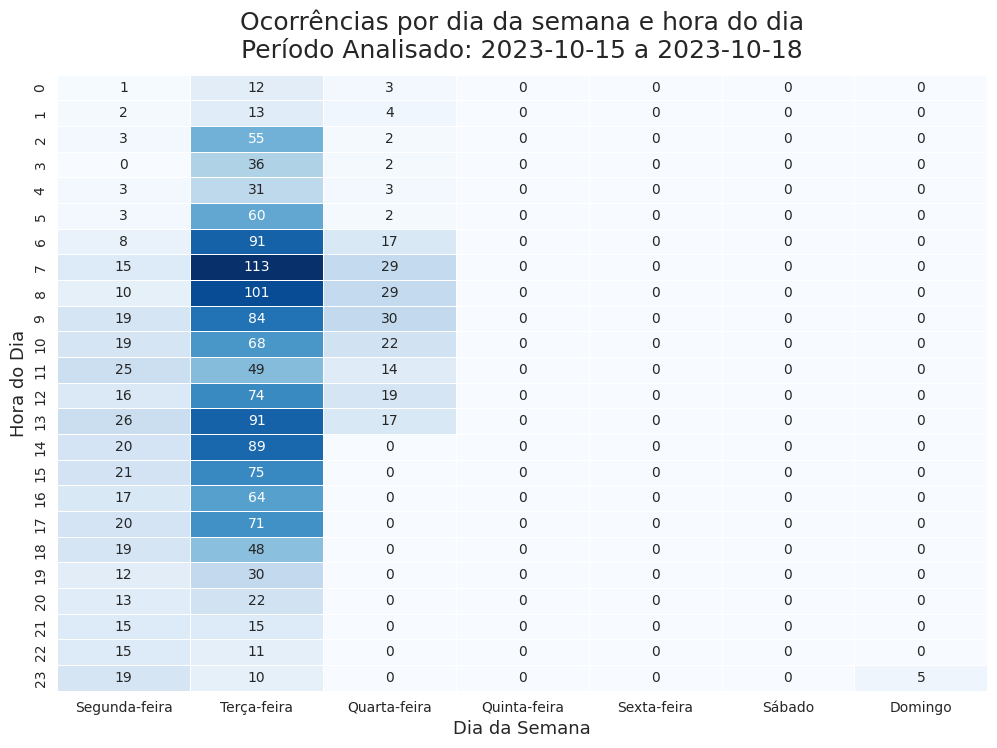

In [ ]:
# Extract the hour and the day of the week
data['hour'] = data['dateTime.sec'].dt.hour
data['day_of_week'] = data['dateTime.sec'].dt.day_name()

# Create a crosstab of hour and day of the week
heatmap_data = pd.crosstab(data['hour'], data['day_of_week'])

# Portuguese days mapping
days_portuguese = {
    "Monday": "Segunda-feira",
    "Tuesday": "Terça-feira",
    "Wednesday": "Quarta-feira",
    "Thursday": "Quinta-feira",
    "Friday": "Sexta-feira",
    "Saturday": "Sábado",
    "Sunday": "Domingo"
}
data['day_of_week_pt'] = data['day_of_week'].map(days_portuguese)

# Create a pivot table for the heatmap data
heatmap_data = data.pivot_table(index='hour', columns='day_of_week_pt', values='id', aggfunc='count', fill_value=0)

# Sort the days of the week in Portuguese
ordered_days = ["Segunda-feira", "Terça-feira", "Quarta-feira", "Quinta-feira", "Sexta-feira", "Sábado", "Domingo"]


# Ensure all days are present in the heatmap, even if there's no data for them
for day in ordered_days:
    if day not in heatmap_data.columns:
        heatmap_data[day] = 0
heatmap_data = heatmap_data[ordered_days]  # ensure columns are ordered correctly

# Create the heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt="g", linewidths=.5,cbar=False)
heatmap.set_title(f'Ocorrências por dia da semana e hora do dia\nPeríodo Analisado: {start_date_str} a {end_date_str}', fontdict={'fontsize': 18}, pad=12)
heatmap.set_xlabel('Dia da Semana', fontsize=13)
heatmap.set_ylabel('Hora do Dia', fontsize=13)
plt.show()

#### Número de Ocorrências por Tipo (top 20)

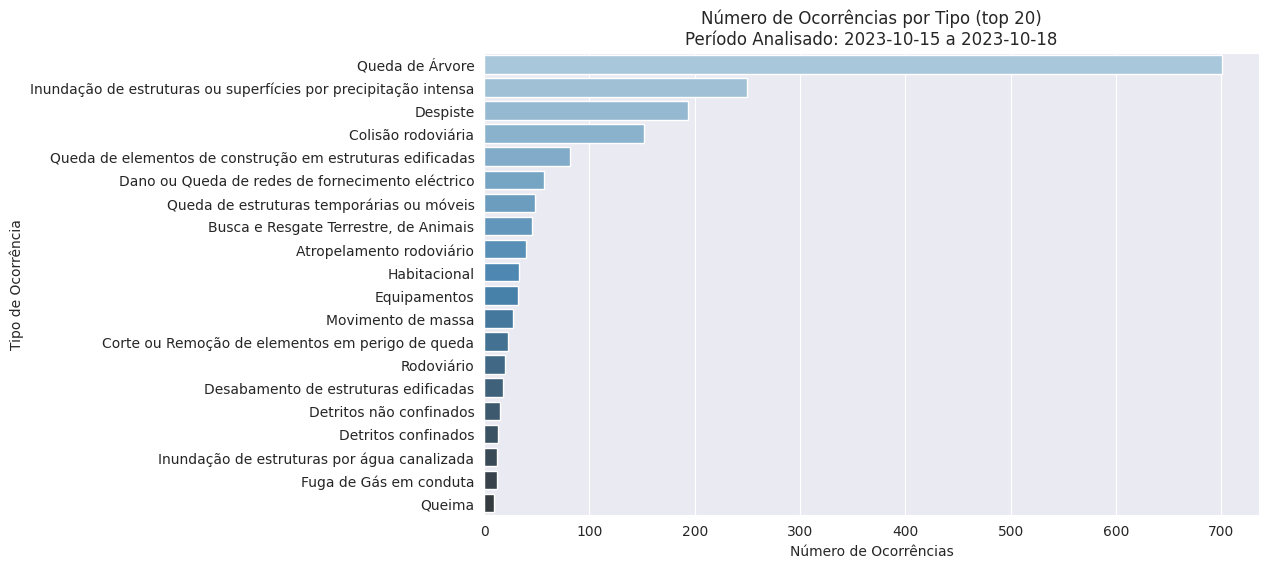

In [ ]:
# Count the number of each type of incident. The number in head can be modified to show more, or less, types of occurrence
incident_counts = incident_data_full['natureza'].value_counts().head(20)

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=incident_counts.values, y=incident_counts.index, palette="Blues_d")
plt.title(f'Número de Ocorrências por Tipo (top 20)\nPeríodo Analisado: {start_date_str} a {end_date_str}')
plt.xlabel('Número de Ocorrências')
plt.ylabel('Tipo de Ocorrência')
plt.show()

#### Número de Ocorrências por Distrito e por Tipo de Ocorrência (top 10)

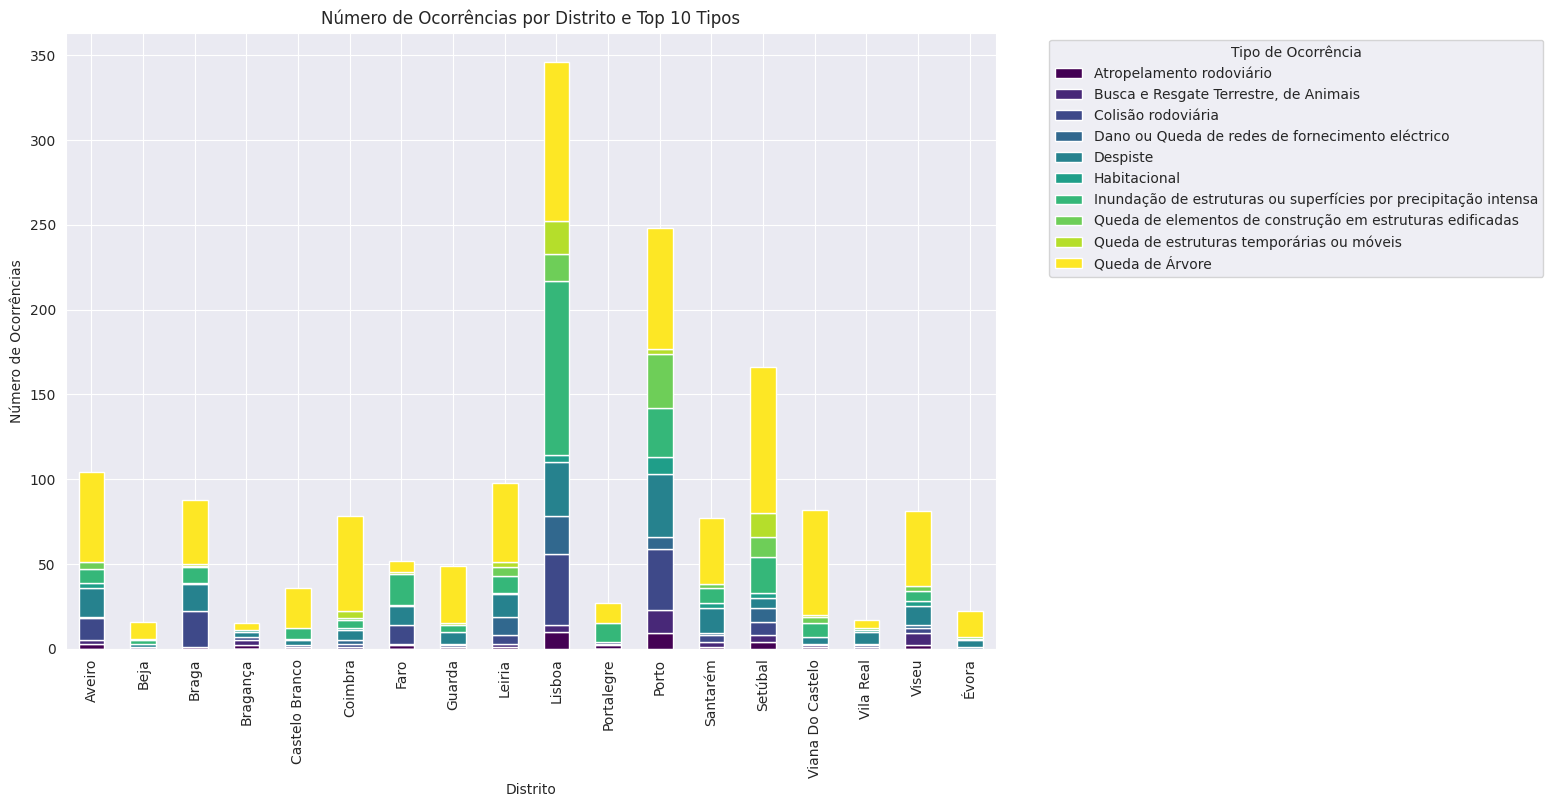

In [ ]:
# Select the top 10 most common incident types
top_10_incidents = incident_data_full['natureza'].value_counts().nlargest(10)

# Filter the data to include only the top 10 incident types
top_10_incident_types = incident_data_full[incident_data_full['natureza'].isin(top_10_incidents.index)]

# Create a crosstab of district and top 10 incident types
district_type_ct = pd.crosstab(top_10_incident_types['district'], top_10_incident_types['natureza'])

# Create a stacked bar chart for the top 10 incidents
district_type_ct.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Número de Ocorrências por Distrito e Top 10 Tipos')
plt.xlabel('Distrito')
plt.ylabel('Número de Ocorrências')
plt.legend(title='Tipo de Ocorrência', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### RESPONSE TIMES

In [ ]:
# Convert 'created.sec' and 'updated.sec' from Unix time to regular datetime
incident_data_full['created_datetime'] = pd.to_datetime(incident_data_full['created.sec'], unit='s')
incident_data_full['updated_datetime'] = pd.to_datetime(incident_data_full['updated.sec'], unit='s')

# Calculate the response time in minutes
incident_data_full['response_time'] = (incident_data_full['updated_datetime'] - incident_data_full['created_datetime']).dt.total_seconds() / 60.0  # convert to minutes


     created_datetime    updated_datetime  response_time
0 2023-10-15 23:24:11 2023-10-16 00:22:18      58.116667
1 2023-10-15 23:26:03 2023-10-16 00:22:18      56.250000
2 2023-10-15 23:32:03 2023-10-16 00:24:11      52.133333
3 2023-10-15 23:36:09 2023-10-16 03:10:22     214.216667
4 2023-10-16 00:08:11 2023-10-16 01:30:21      82.166667


#### Box Plot para os tempos de reposta

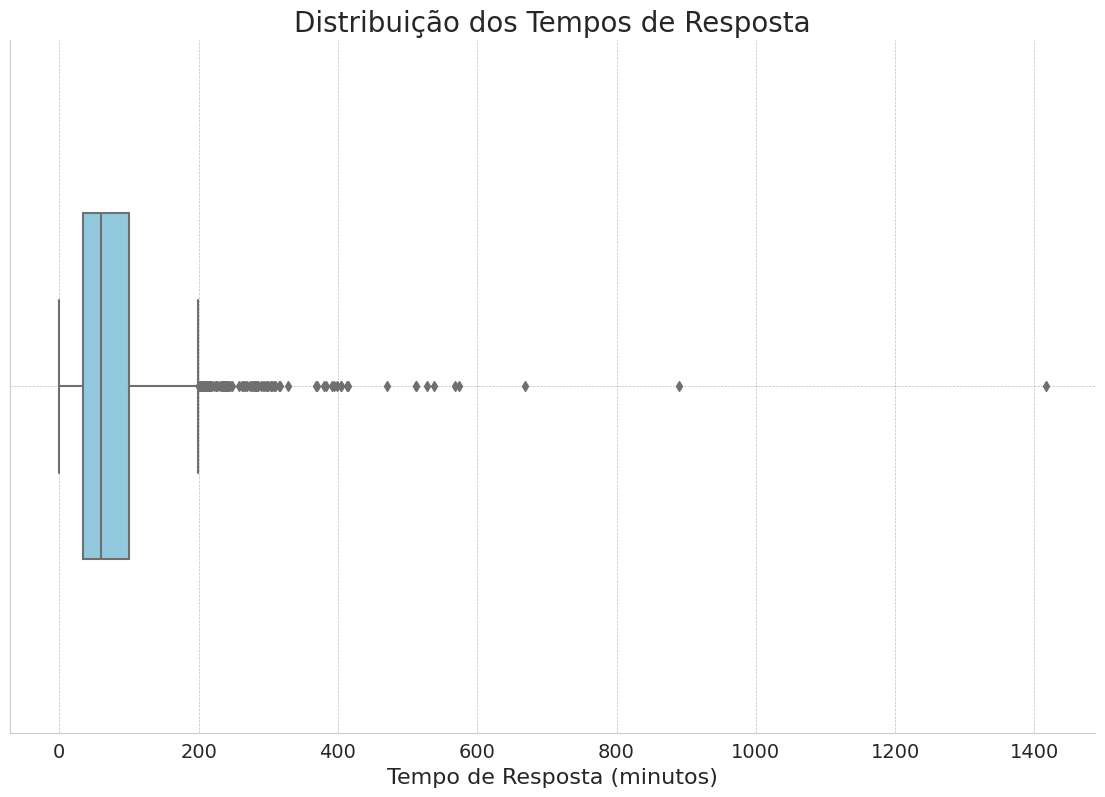

In [ ]:
# Box plot for response times
# Set style and color scheme
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create a larger plot
plt.figure(figsize=(14, 9))

# Create the boxplot with enhanced aesthetics
sns.boxplot(x=incident_data_full['response_time'], width=0.5, color="skyblue")

# Add a title and labels with larger fonts for clarity
plt.title('Distribuição dos Tempos de Resposta', fontsize=20)
plt.xlabel('Tempo de Resposta (minutos)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show gridlines for easier interpretation
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Remove the box around the plot to simplify the visuals (optional)
sns.despine()

# Show the plot
plt.show()

#### Histograma dos tempos de resposta

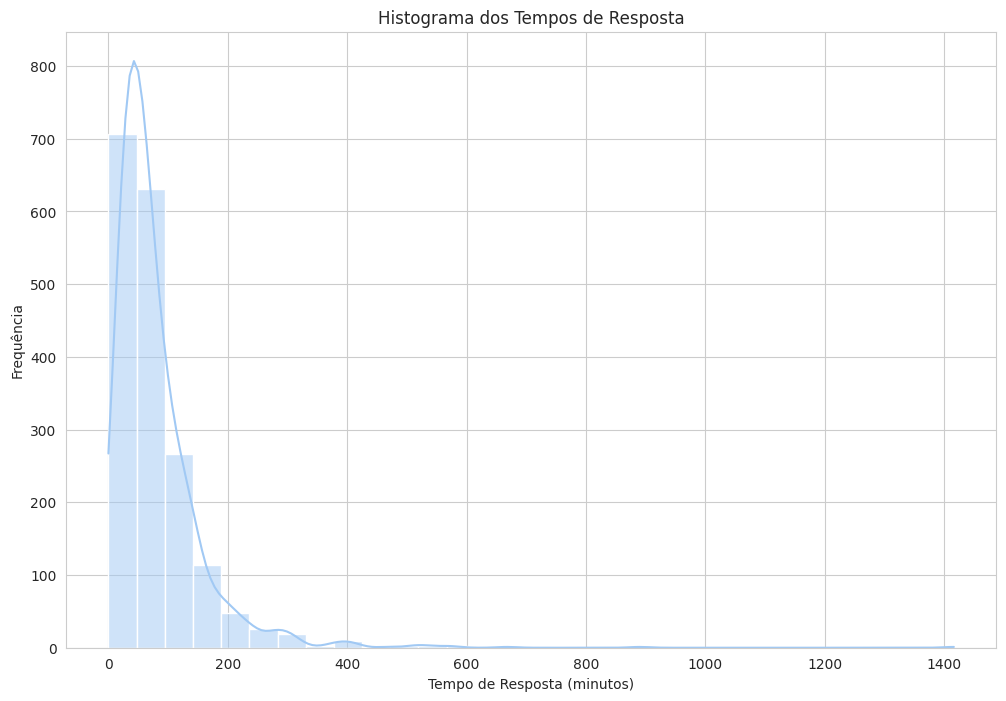

In [ ]:
# Histogram for response times
plt.figure(figsize=(12, 8))
sns.histplot(incident_data_full['response_time'], bins=30, kde=True)
plt.title('Histograma dos Tempos de Resposta')
plt.xlabel('Tempo de Resposta (minutos)')
plt.ylabel('Frequência')
plt.show()